# IMDb Ratings Prediction - Ayaan Danish

Importing libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import HuberRegressor

Reading the data

In [16]:
df = pd.read_csv('imdb.csv', encoding='ISO-8859-1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


## Data Understanding and Cleaning

Checking dataset rows and columns

In [17]:
df.shape

(15509, 10)

Checking number of null values in each column

In [18]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

Dropping all null rows to clean the data

In [19]:
df.dropna(inplace=True)
df.isna().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

Checking column types, we can see that a few types need to be changed to numeric form

In [20]:
df.dtypes

Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

Remove the parentheses from the Year column and convert to integer 

In [21]:
df['Year'] = df['Year'].str.replace(r'[\(\)]', '', regex=True).astype('int64')

Remove the 'mins' from the Duration column and convert to integer, also rename column to show unit

In [22]:
df['Duration'] = df['Duration'].str.replace(r' min', '', regex=True).astype('int64')
df.rename(columns={'Duration': 'Duration (mins)'}, inplace=True)

Remove the ',' from Votes column and convert to integer

In [23]:
df['Votes'] = df['Votes'].str.replace(',', '').astype('int64')

Checking updated column types

In [24]:
df.dtypes

Name                object
Year                 int64
Duration (mins)      int64
Genre               object
Rating             float64
Votes                int64
Director            object
Actor 1             object
Actor 2             object
Actor 3             object
dtype: object

Checking key statistics for the data 

In [25]:
df.describe()

,Year,Duration (mins),Rating,Votes
count,5659.000000,5659.000000,5659.000000,5659.000000
mean,1996.247570,133.439124,5.898533,2697.649585
std,19.741839,25.319939,1.381165,13651.503584
min,1931.000000,21.000000,1.100000,5.000000
25%,1983.000000,119.000000,5.000000,30.000000
50%,2002.000000,135.000000,6.100000,131.000000
75%,2013.000000,150.000000,6.900000,922.500000
max,2021.000000,321.000000,10.000000,591417.000000


## Data Visualization

Text(0.5, 1.0, 'Correlation Heatmap of numerical features')

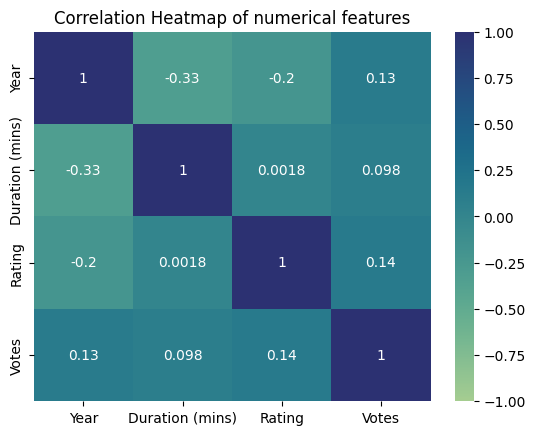

In [26]:
ax = sns.heatmap(data=df.corr(numeric_only=True), cmap='crest', annot=df.corr(numeric_only=True), vmin=-1)
ax.set_title('Correlation Heatmap of numerical features')

Apply log normalization to the Votes since the data is too skewed to one side

In [27]:
df['Votes'] = df['Votes'].apply(lambda x: math.log(x))

<Axes: title={'center': 'Votes Histogram'}, ylabel='Frequency'>

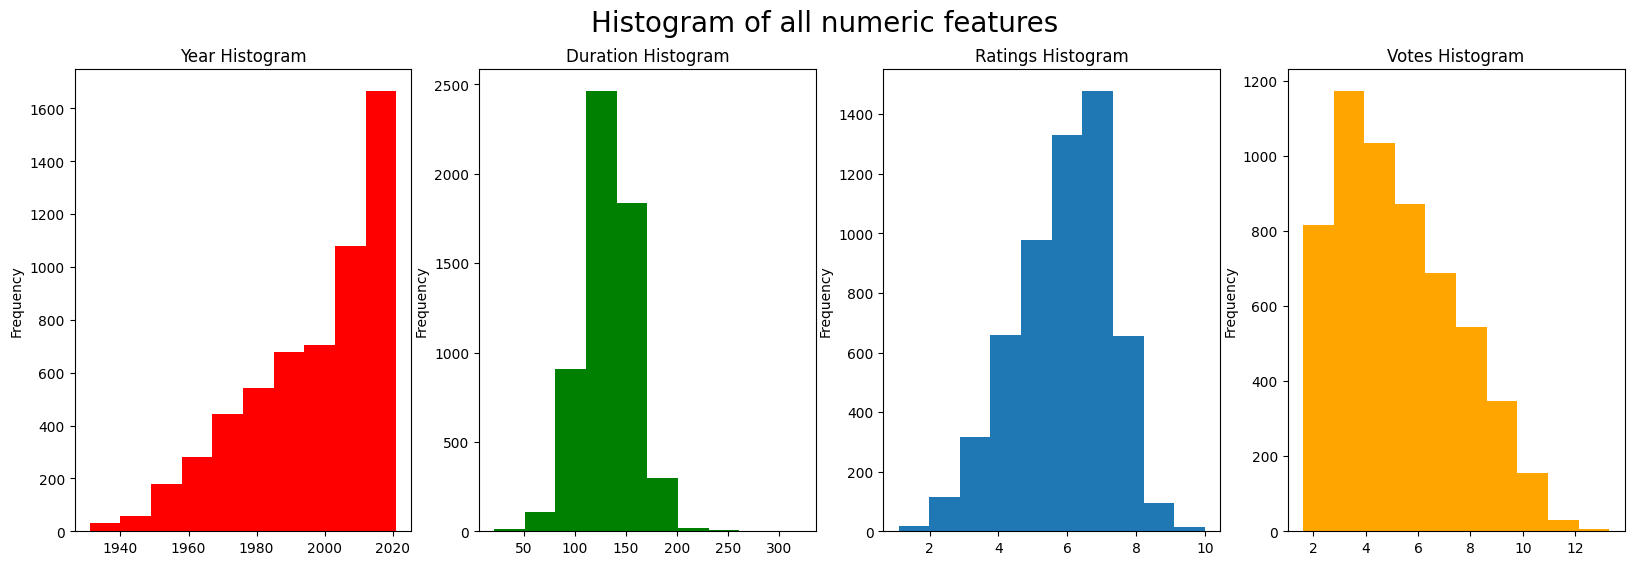

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(20,6))
fig.suptitle('Histogram of all numeric features', fontsize='20')
df['Year'].plot(kind='hist', ax=axes[0], title='Year Histogram', color='red')
df['Duration (mins)'].plot(kind='hist', ax=axes[1], title='Duration Histogram', color='green')
df['Rating'].plot(kind='hist', ax=axes[2], title='Ratings Histogram')
df['Votes'].plot(kind='hist', ax=axes[3], color='orange', title='Votes Histogram')

<Axes: xlabel='Duration (mins)', ylabel='Rating'>

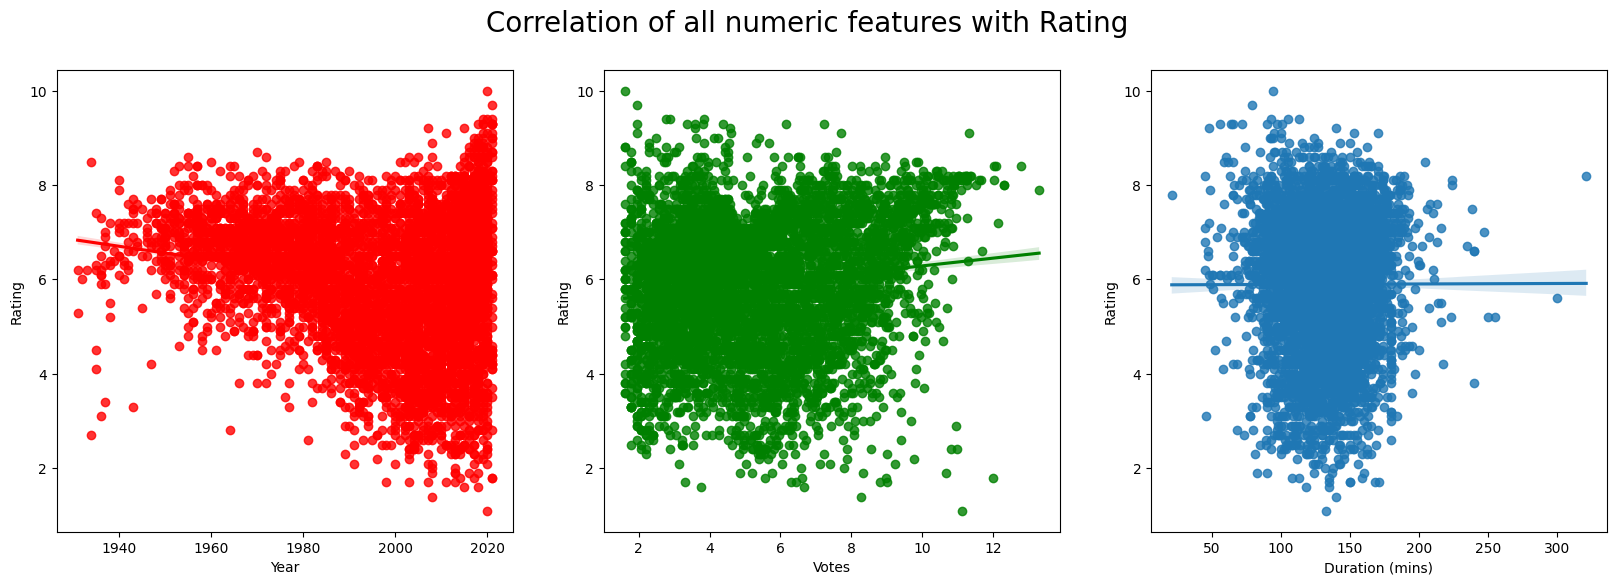

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Correlation of all numeric features with Rating', fontsize='20')
sns.regplot(data=df, x=df['Year'], y=df['Rating'], ax=axes[0], color='red')
sns.regplot(data=df, x=df['Votes'], y=df['Rating'], ax=axes[1], color='green')
sns.regplot(data=df, x=df['Duration (mins)'], y=df['Rating'], ax=axes[2])

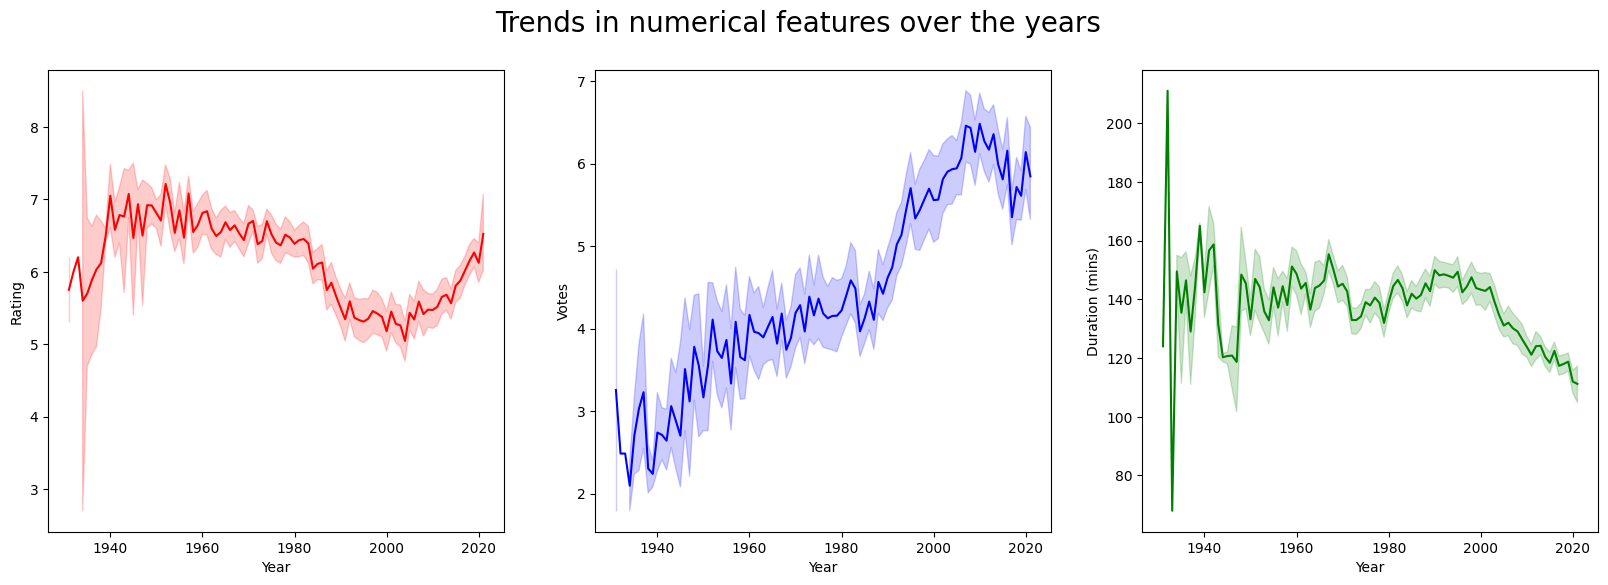

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Trends in numerical features over the years', fontsize='20')
ax = sns.lineplot(x=df['Year'], y=df['Rating'], data=df, color='red', ax=axes[0])
ax = sns.lineplot(x=df['Year'], y=df['Votes'], data=df, color='blue', ax=axes[1])
ax = sns.lineplot(x=df['Year'], y=df['Duration (mins)'], data=df, color='green', ax=axes[2])

Text(0.5, 0.98, 'Top 10 Best and Worst Rated Movies')

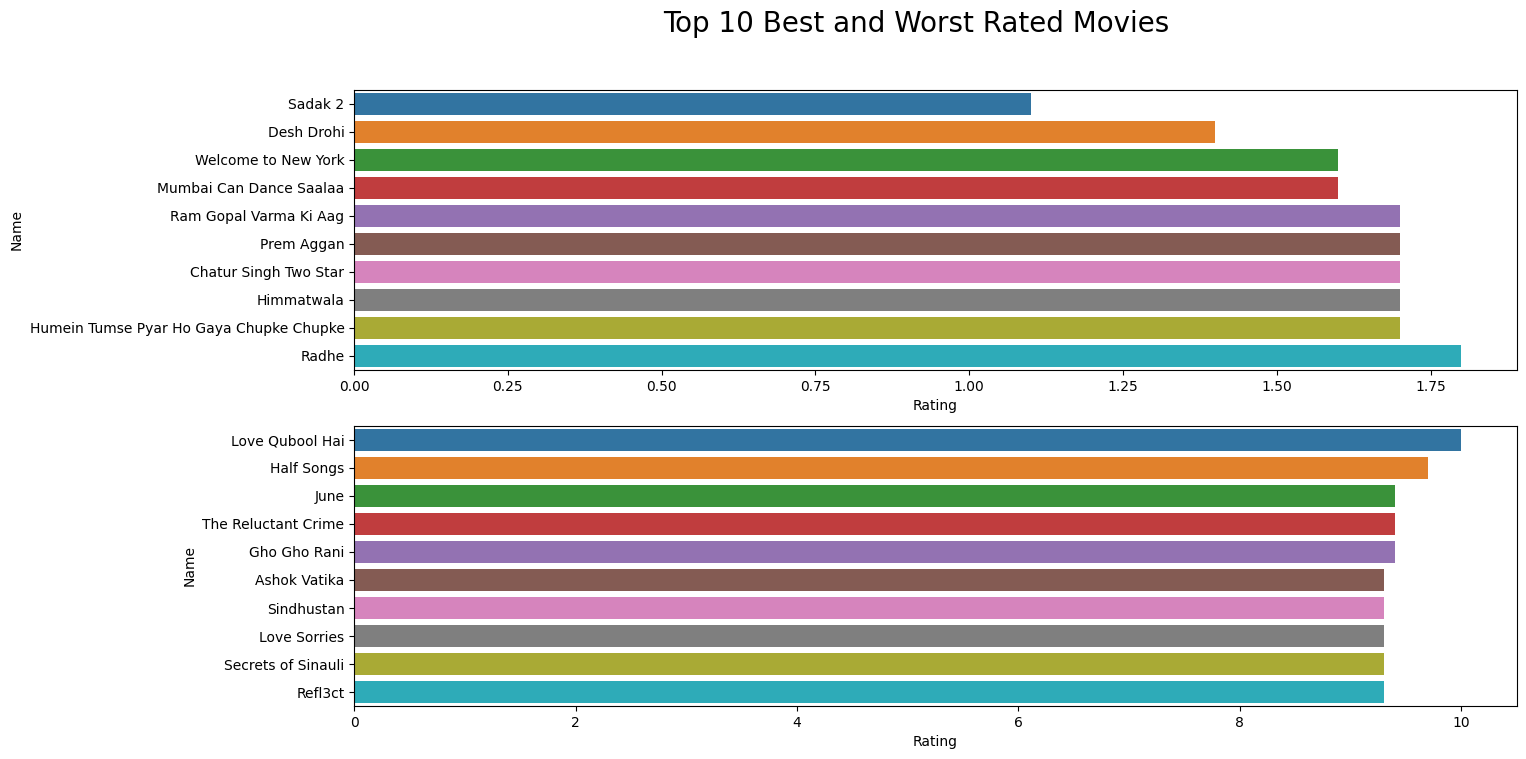

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))

top10 = df[['Name','Rating']].sort_values(by='Rating', ascending=False).iloc[0:10]
worst10 = df[['Name','Rating']].sort_values(by='Rating', ascending=True).iloc[0:10]
sns.barplot(y=worst10['Name'], x=worst10['Rating'], ax=axes[0])
sns.barplot(y=top10['Name'], x=top10['Rating'], ax=axes[1])
plt.suptitle('Top 10 Best and Worst Rated Movies', fontsize='20')

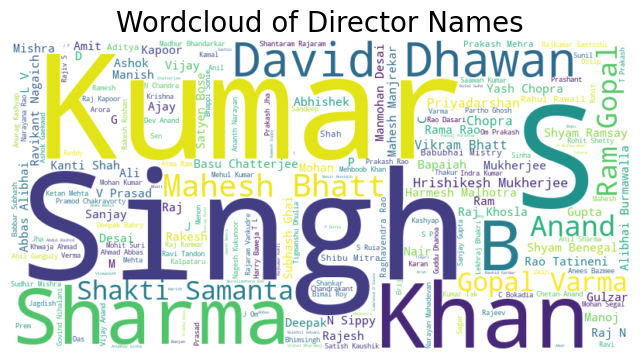

In [18]:
director_names = ' '.join(df['Director'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(director_names)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Director Names', fontsize=20)
plt.show()

## Data Modeling

Preparing input and target features

In [19]:
X = pd.get_dummies(df.drop(columns=['Rating', 'Name'], axis=1))
y = df['Rating']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Defining function to evaluate models and make table of results

In [87]:
def evaluate_regression_model(models):
    results_df = pd.DataFrame(
    columns=['Mean Squared Error', 'Mean Absolute Error', 'R-Squared Coefficient Score', 'Explained Variance Score'])

    for model, model_name in models:
        print(f"Training {model_name}...")
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        # Calculate metrics
        metrics = {
            'Model': model_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred, squared=True),
            'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
            'R-Squared Coefficient Score': r2_score(y_test, y_pred),
            'Explained Variance Score': explained_variance_score(y_test, y_pred)
        }
    
        results_df.loc[model_name] = metrics

    return results_df

Training and evaluating models

In [88]:
results_df = evaluate_regression_model([
    (LinearRegression(), 'Linear Regression'),
    (RandomForestRegressor(max_features='sqrt', min_samples_split=5, n_estimators=200, n_jobs=-1, random_state=0), 'Random Forest Regression'),
    (DecisionTreeRegressor(), 'Decision Tree Regression'),
    (Ridge(), 'Ridge Regression'),
    (Lasso(), 'Lasso Regression'),
    (ElasticNet(), 'ElasticNet Regression'),
    (GradientBoostingRegressor(), 'Gradient Boosting Regressor'),
    (SVR(), 'Support Vector Regression'),
    (KNeighborsRegressor(), 'K-Nearest Neighbors Regression'),
    (GaussianProcessRegressor(), 'Gaussian Process Regression'),
    (HuberRegressor(), 'Huber Regression'),
 ])

Training Linear Regression...
Training Random Forest Regression...
Training Decision Tree Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet Regression...
Training Gradient Boosting Regressor...
Training Support Vector Regression...
Training K-Nearest Neighbors Regression...
Training Gaussian Process Regression...
Training Huber Regression...


C:\Users\Ayaan Danish\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model results sorted by absolute error (how far their prediction was off from the actual rating)

In [91]:
results_df.sort_values(by='Mean Absolute Error')

,Mean Squared Error,Mean Absolute Error,R-Squared Coefficient Score,Explained Variance Score
Random Forest Regression,1.214445e+00,0.840186,3.487868e-01,3.496135e-01
Gradient Boosting Regressor,1.281522e+00,0.862451,3.128185e-01,3.128190e-01
Ridge Regression,1.418423e+00,0.907400,2.394095e-01,2.394622e-01
Huber Regression,1.479587e+00,0.946590,2.066119e-01,2.066210e-01
K-Nearest Neighbors Regression,1.619008e+00,0.981392,1.318512e-01,1.322776e-01
Decision Tree Regression,1.901601e+00,1.019111,-1.968161e-02,-1.474132e-02
ElasticNet Regression,1.727167e+00,1.047730,7.385351e-02,7.387520e-02
Lasso Regression,1.785292e+00,1.072692,4.268568e-02,4.270415e-02
Support Vector Regression,1.841643e+00,1.083976,1.246901e-02,2.676365e-02
Gaussian Process Regression,3.557209e+01,5.804380,-1.807456e+01,-8.770406e-03
